In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Note - The written parts are included in the respective deliverable section. No seperate PDF enclosed

# Part 1 Deliverable

In [ ]:
from torch.nn import Module, Linear, ReLU
from torch.nn.functional import softmax
from torch import matmul, zeros, concat, cat
from math import sqrt

class TransformerLayer(Module):
    def __init__(self, d_model, d_internal, d_ff, n_heads, max_seq_len=20):
        """
        :param d_model: The dimension of the inputs and outputs of the layer
            (note that the inputs and outputs have to be the same size for the residual connection to work)
        :param d_internal: The "internal" dimension used in the self-attention computation.
            Your keys and queries should both be of this length per head.
        :param d_ff: The "feed forward" dimension used in the feed-foward computation.
            You should have a linear transformation from d_model to d_ff, and then following an activation, d_ff to d_model.
        :param n_heads: The number of attention heads used.
            Keep this number low for efficiency.
        :param max_seq_len: The max sequence length.
        """
        super().__init__()

        self.d_model = d_model
        self.d_internal = d_internal
        self.n_heads = n_heads
        self.max_seq_len = max_seq_len
        self.last_map = zeros(n_heads,max_seq_len,max_seq_len)

        # TODO 1.1) Define the QKV linear transformations
        self.q_proj = Linear(d_model, d_internal * n_heads)
        self.k_proj = Linear(d_model, d_internal * n_heads)
        self.v_proj = Linear(d_model, d_internal * n_heads)

        # TODO 1.2) Define the multi-head attention linear transformations
        self.mha_proj = Linear(d_internal * n_heads, d_model)

        # TODO 1.3) Define the feedforward
        self.ff1 = Linear(d_model, d_ff)
        self.activation = ReLU()
        self.ff2 = Linear(d_ff, d_model)


    def forward(self, input_vecs):
        """
        :param input_vecs: an input tensor of shape [seq len, d_model]
        :return: a tensor of shape [seq len, d_model] representing the log probabilities of each position in the input
        """

        q,k,v = input_vecs,input_vecs,input_vecs

        # TODO 1.5) Calculate MHA up to the attention map
        Q = self.q_proj(q).view(-1, self.n_heads, self.d_internal).transpose(0, 1)
        K = self.k_proj(k).view(-1, self.n_heads, self.d_internal).transpose(0, 1)
        V = self.v_proj(v).view(-1, self.n_heads, self.d_internal).transpose(0, 1)

        cosine_scores = matmul(Q, K.transpose(-2, -1)) / (sqrt(self.d_internal))
        attn_map = softmax(cosine_scores, dim=-1)

        # TODO 1.6) Cache latest attention map
        self.last_map = attn_map.detach().clone()

        # TODO 1.7) Complete MHA
        attn_delta = matmul(attn_map, V)
        attn_delta = attn_delta.transpose(0, 1).contiguous().view(self.max_seq_len, self.n_heads * self.d_internal)
        attn_delta = self.mha_proj(attn_delta)

        # TODO 1.8) Add residual
        x = input_vecs + attn_delta

        # TODO 1.9) Apply feed forward and add second residual
        x = x + self.ff2(self.activation(self.ff1(x)))

        return x

In [ ]:
import random
from torch import manual_seed,randn
from numpy import round as npround

random.seed(42)
manual_seed(42)

# Single-head test case
input_tensor = randn(5,8)

sh_attn = TransformerLayer(d_model=8,d_internal=32,d_ff=64, n_heads=1,max_seq_len=5)
print('Single-head output')
print(npround(sh_attn(input_tensor).detach().numpy(),4),'\n')
print('Single-head attention map')
print(npround(sh_attn.last_map.detach().numpy(),4),'\n')

print('='*60,'\n')

# Mutlti-head test case
sh_attn = TransformerLayer(d_model=8,d_internal=16,d_ff=128, n_heads=2,max_seq_len=5)

print('Multi-head output')
print(npround(sh_attn(input_tensor).detach().numpy(),4),'\n')
print('Multi-head attention maps')
print(npround(sh_attn.last_map.detach().numpy(),4))

Single-head output
[[ 2.2838  1.5244  0.8004 -2.9931  0.589  -0.8144 -0.1878 -2.4291]
 [-1.1199  1.5985 -0.2764 -1.6976 -0.5537 -0.2992 -1.1663 -0.1034]
 [ 1.6057 -0.0639 -0.236   0.0499 -0.5856  1.5798  0.844   0.9629]
 [ 0.3906  0.0176  1.5224 -1.2355  1.6741  1.1942 -1.2787 -0.9399]
 [-1.5059  1.3385 -0.244   1.3421  1.5637  0.644  -1.9173 -1.3539]] 

Single-head attention map
[[[0.1903 0.3172 0.1341 0.1319 0.2265]
  [0.2291 0.2353 0.2829 0.1432 0.1095]
  [0.2137 0.1621 0.1954 0.1957 0.2331]
  [0.1552 0.1517 0.1744 0.2308 0.288 ]
  [0.1125 0.1147 0.1225 0.1859 0.4644]]] 


Multi-head output
[[ 1.5158  1.0291  0.5479 -1.8851  0.5383 -1.0615 -0.0882 -1.7973]
 [-0.6814  1.7653 -0.6277 -1.1421 -0.2932 -0.0086 -0.9963  0.5146]
 [ 1.4643 -0.4265 -0.5724  0.9202 -0.3251  1.3543  1.1753  1.6216]
 [-0.0789  0.3658  1.0965 -0.6266  1.7939  1.0766 -1.3486 -0.6459]
 [-1.8123  0.8444 -0.5449  2.7515  2.1552 -0.337  -1.1889 -1.4461]] 

Multi-head attention maps
[[[0.0688 0.2591 0.1634 0.1492 0.35

# Part 2 Deliverable

In [ ]:
from torch import tensor, LongTensor, FloatTensor, log, concat, cat
from torch.nn import Sequential, Embedding
from torch.nn.functional import log_softmax

class Transformer(Module):
    def __init__(self, vocab_size, max_seq_len, d_model, d_internal, num_classes, d_ff, num_layers, num_heads):
        """
        :param vocab_size: vocabulary size of the embedding layer
        :param max_seq_len: max sequence length that will be fed to the model; should be 20
        :param d_model: see TransformerLayer
        :param d_internal: see TransformerLayer
        :param d_ff: see TransformerLayer
        :param num_classes: number of classes predicted at the output layer; should be 3
        :param num_layers: number of TransformerLayers to use; can be whatever you want
        :param num_layers: number of heads per TransformerLayer; can be whatever you want
        """
        super().__init__()
        self.max_seq_len = max_seq_len

        layers = []
        for i in range(num_layers):
            layer = TransformerLayer(d_model=d_model, d_internal=d_internal,n_heads=num_heads,d_ff=d_ff,max_seq_len=max_seq_len)
            layers.append(layer)
        self.encoders = Sequential(*layers)
        self.decoder = Linear(d_model, num_classes)

        # TODO 2.1) Define word embedding
        self.embedding = Embedding(vocab_size, d_model)

        # TODO 2.2) Define positional encoding
        self.positional_encoding = Embedding(max_seq_len, d_model)


    def forward(self, indices):
        """
        :param indices: list of input indices
        :return: A tuple of the softmax log probabilities (should be a 20x3 matrix) and a list of the attention
        maps you use in your layers (can be variable length, but each should be a 20x20 matrix)
        """
        # TODO 2.3) Apply word embedding and positional encoding
        positions = torch.arange(0, self.max_seq_len).unsqueeze(0)
        x = self.embedding(indices) + self.positional_encoding(positions)

        # TODO 2.4) Layer Forward Passes
        maps = []
        for layer in self.encoders:
            x = layer(x)
            maps.append(layer.last_map.clone())

        # TODO 2.5) Return the log-probabilites and cached maps for every layer and head
        x = log_softmax(self.decoder(x), dim=-1)

        return (x, maps)

In [ ]:
import torch
from torch import LongTensor

len_vocab = 4
max_seq_len = 5
d_model = 16
d_internal = 32
num_classes = 3
d_ff = 64
num_layers = 1
num_heads = 1

model = Transformer(len_vocab, max_seq_len, d_model, d_internal, num_classes, d_ff, num_layers, num_heads)
indices = LongTensor([1, 1, 2, 2, 3])
word_embeddings = model.embedding(indices)
positional_encodings = model.positional_encoding(torch.arange(0, max_seq_len).unsqueeze(0))

combined_embedding = word_embeddings + positional_encodings

print("Embedding for [1, 1, 2, 2, 3]:")
print(combined_embedding.detach().numpy())

Embedding for [1, 1, 2, 2, 3]:
[[[ 0.4186684   0.23510438 -0.6107169   3.0295491   0.16678578
   -0.62968546 -0.7690521   0.9462022   0.4572121  -0.6047108
   -0.68399614  0.8667402  -1.310941   -0.00681603 -1.4915724
    0.17301592]
  [ 1.0458289  -1.2716849  -0.40362847  2.9676557  -0.23475009
    1.7390447  -1.7948766   1.1834515  -1.6738364   2.7369764
   -0.429146   -1.394268   -1.2886183   1.627286   -1.3527882
   -0.04709774]
  [ 0.8472589  -1.6879438  -0.6164624  -1.3952848   0.7498909
    0.6671873  -1.4888222  -0.42330068  2.980894    1.8998936
    1.5472401  -2.0640717  -1.0915943   1.1186677   2.0465944
    0.49191552]
  [-0.86616033 -2.127572   -0.2716141  -1.4482749   0.6226211
    1.1797339  -1.4178612   0.97628945 -0.31633556  4.680901
    2.6893902  -1.640797    0.8933296   2.1535513   0.9779425
    0.34865263]
  [-0.33789957 -2.656756    1.2438041   0.00766084 -0.07139169
    0.13314116  0.7927222  -0.14007616 -1.4930135  -0.65333223
    1.4033277  -1.0373664   0.4768

# Part 3 Deliverable

In [ ]:
import numpy as np
from torch import LongTensor

def task1(input: str) -> LongTensor:
    output = np.zeros(len(input))
    for i in range(0, len(input)):
        output[i] = min(2, len([c for c in input[0:i] if c == input[i]]))
    return LongTensor(output)

def task2(input: str) -> LongTensor:
    output = np.zeros(len(input))
    for i in range(0, len(input)):
        output[i] = min(2, len([c for c in input if c == input[i]]) - 1)
    return LongTensor(output)

def indexer(input: str) -> LongTensor:
    # TODO 3.1) map string to character index LongTensor.
    # Note that all the characters are either spaces or the lowercase alphabet
    alphabet = 'abcdefghijklmnopqrstuvwxyz '
    char_to_index = {char: idx for idx, char in enumerate(alphabet)}
    return LongTensor([char_to_index[char] for char in input])


with open(f'/content/drive/MyDrive/A4_v1.1/lettercounting-train.txt','r',encoding='utf8') as train_file:
    # TODO 3.2) Process train_file
    train_data = [line.rstrip('\n') for line in train_file]
    train_indices = [indexer(line) for line in train_data]
    train_task1 = [task1(line) for line in train_data]
    train_task2 = [task2(line) for line in train_data]

with open(f'/content/drive/MyDrive/A4_v1.1/lettercounting-dev.txt','r',encoding='utf8') as eval_file:
    # TODO 3.3) Process eval_file
    eval_data = [line.rstrip('\n') for line in eval_file]
    eval_indices = [indexer(line) for line in eval_data]
    eval_task1 = [task1(line) for line in eval_data]
    eval_task2 = [task2(line) for line in eval_data]

In [ ]:
example_string = "ed by rank and file"
example_id_tensor = indexer(example_string)
example_task1_tensor = task1(example_string)
example_task2_tensor = task2(example_string)
print(example_id_tensor)
print(example_task1_tensor)
print(example_task2_tensor)

tensor([ 4,  3, 26,  1, 24, 26, 17,  0, 13, 10, 26,  0, 13,  3, 26,  5,  8, 11,
         4])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 2, 0, 0, 0, 1])
tensor([1, 1, 2, 0, 0, 2, 0, 1, 1, 0, 2, 1, 1, 1, 2, 0, 0, 0, 1])


In [ ]:
#Note, if you are unable to store the outputs from plt.show(), configure the plot_maps function to use savefig()

import matplotlib.pyplot as plt

def plot_maps(maps,text):
    maps = maps.detach().numpy()
    num_layers = maps.shape[0]
    num_heads = maps.shape[1]
    fig, axs = plt.subplots(num_heads,num_layers,figsize=(num_layers*4,num_heads*4))

    for head_index in range(num_heads):
        for layer_index in range(num_layers):
            if num_heads==1 and num_layers == 1:
                ax = axs
            elif num_layers==1:
                ax = axs[head_index]
            elif num_heads==1:
                ax = axs[layer_index]
            else:
                ax = axs[head_index][layer_index]
            attn_map = maps[layer_index][head_index]
            ax.imshow(attn_map, cmap='hot', interpolation='nearest')
            ax.set_xticks(np.arange(len(text)), labels=text)
            ax.set_yticks(np.arange(len(text)), labels=text)
            ax.xaxis.tick_top()

    # if not using juypter notebook
    #plt.savefig("maps.png")
    # otherwise
    plt.show()

# Part 4 Deliverable

In [ ]:
# Loss functions
from torch.nn import NLLLoss,BCELoss,CrossEntropyLoss
# Optimizers
from torch.optim import SGD, Adam, AdamW, Adadelta
# Learning rate schedulers (optional)
from torch.optim.lr_scheduler import LinearLR, StepLR, CosineAnnealingLR

from torch import no_grad
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import random
random.seed(0)

def train_loop(model, train_indices, eval_indices, train_task, eval_task, num_epochs, optimizer, loss_function, scheduler):
  train_losses, eval_losses = [], []
  train_steps, eval_steps = [], []
  global_step = 0

  for ep in range(num_epochs):
      model.train()
      total_loss = 0
      log_interval = random.randint(100, 250)
      eval_log_interval = random.randint(5, 10)

      for step, batch in enumerate(train_indices):
          optimizer.zero_grad()
          logits, _ = model(batch)
          logits = logits.view(-1, 3)
          loss = loss_function(logits, train_task[step])
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          global_step += 1

          if (step + 1) % log_interval == 0:
              train_losses.append(total_loss / (step + 1))
              train_steps.append(global_step)

              if len(train_losses) % eval_log_interval == 0:
                  model.eval()
                  eval_loss, predictions, golds = 0, [], []
                  with no_grad():
                      for step, batch in enumerate(eval_indices):
                          logits, _ = model(batch)
                          logits = logits.view(-1, 3)
                          eval_loss += loss_function(logits, eval_task[step]).item()
                          preds = logits.argmax(dim=-1)
                          predictions.extend(preds.tolist())
                          golds.extend(eval_task[step].tolist())

                  eval_losses.append(eval_loss / len(eval_indices))
                  eval_steps.append(global_step)

                  accuracy = accuracy_score(golds, predictions)
                  f1 = f1_score(golds, predictions, average='macro')
                  print(f"Epoch {ep+1}, Step {global_step}, Train Loss: {train_losses[-1]:.4f}, Eval Loss: {eval_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

      if scheduler is not None:
        scheduler.step()
        print(f"Epoch {ep+1} completed. Learning rate: {scheduler.get_last_lr()[0]:.6f}")
  return train_losses, train_steps, eval_losses, eval_steps

def plot_losses(train_losses, train_steps, eval_losses, eval_steps):
    plt.plot(train_steps, train_losses, label='Train Loss')
    plt.plot(eval_steps, eval_losses, label='Eval Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title("Training and Evaluation Loss over Time")
    plt.legend()
    plt.show()

Experiments Carried Out to Tune optimizers and hyperparameters - 6

Epoch 1, Step 1374, Train Loss: 0.6622, Eval Loss: 0.5871, Accuracy: 0.7350, F1 Score: 0.6636
Epoch 1, Step 2748, Train Loss: 0.5689, Eval Loss: 0.4030, Accuracy: 0.8235, F1 Score: 0.7586
Epoch 1, Step 4122, Train Loss: 0.4874, Eval Loss: 0.2391, Accuracy: 0.8997, F1 Score: 0.8422
Epoch 1, Step 5496, Train Loss: 0.4139, Eval Loss: 0.1656, Accuracy: 0.9352, F1 Score: 0.8978
Epoch 1, Step 6870, Train Loss: 0.3595, Eval Loss: 0.1001, Accuracy: 0.9626, F1 Score: 0.9383
Epoch 1, Step 8244, Train Loss: 0.3172, Eval Loss: 0.0748, Accuracy: 0.9753, F1 Score: 0.9595
Epoch 1, Step 9618, Train Loss: 0.2839, Eval Loss: 0.0843, Accuracy: 0.9684, F1 Score: 0.9476
Epoch 2, Step 10860, Train Loss: 0.0722, Eval Loss: 0.0941, Accuracy: 0.9624, F1 Score: 0.9393
Epoch 2, Step 11892, Train Loss: 0.0671, Eval Loss: 0.0998, Accuracy: 0.9662, F1 Score: 0.9463
Epoch 2, Step 12924, Train Loss: 0.0653, Eval Loss: 0.0832, Accuracy: 0.9768, F1 Score: 0.9624
Epoch 2, Step 13956, Train Loss: 0.0642, Eval Loss: 0.051

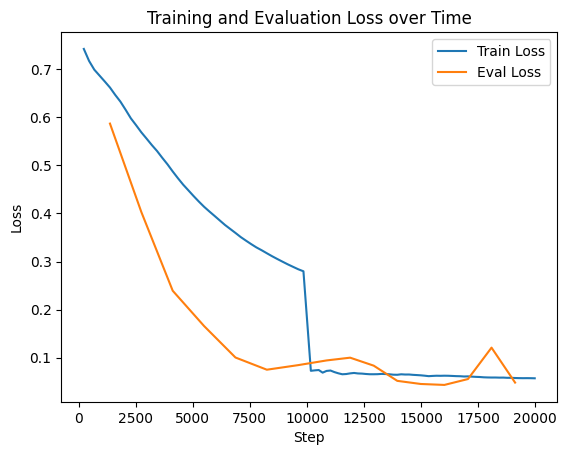

In [ ]:
# Task 1
model = Transformer(vocab_size=27, max_seq_len=20, d_model=64, d_internal=32, num_classes=3, d_ff=128, num_layers=1, num_heads=1)
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 2
loss_function = NLLLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
train_losses, train_steps, eval_losses, eval_steps = train_loop(model, train_indices, eval_indices, train_task1, eval_task1, num_epochs, optimizer, loss_function, None)
plot_losses(train_losses, train_steps, eval_losses, eval_steps)

Epoch 1, Step 1116, Train Loss: 0.8887, Eval Loss: 0.8011, Accuracy: 0.6162, F1 Score: 0.6075
Epoch 1, Step 2232, Train Loss: 0.7952, Eval Loss: 0.6685, Accuracy: 0.6741, F1 Score: 0.6654
Epoch 1, Step 3348, Train Loss: 0.7402, Eval Loss: 0.5911, Accuracy: 0.7181, F1 Score: 0.7092
Epoch 1, Step 4464, Train Loss: 0.7033, Eval Loss: 0.5893, Accuracy: 0.7185, F1 Score: 0.7129
Epoch 1, Step 5580, Train Loss: 0.6751, Eval Loss: 0.5219, Accuracy: 0.7526, F1 Score: 0.7481
Epoch 1, Step 6696, Train Loss: 0.6513, Eval Loss: 0.5173, Accuracy: 0.7559, F1 Score: 0.7515
Epoch 1, Step 7812, Train Loss: 0.6258, Eval Loss: 0.4098, Accuracy: 0.8149, F1 Score: 0.8126
Epoch 1, Step 8928, Train Loss: 0.5979, Eval Loss: 0.3713, Accuracy: 0.8332, F1 Score: 0.8327
Epoch 2, Step 10164, Train Loss: 0.3400, Eval Loss: 0.2998, Accuracy: 0.8697, F1 Score: 0.8672
Epoch 2, Step 11640, Train Loss: 0.3034, Eval Loss: 0.3007, Accuracy: 0.8728, F1 Score: 0.8714
Epoch 2, Step 13116, Train Loss: 0.2870, Eval Loss: 0.2639

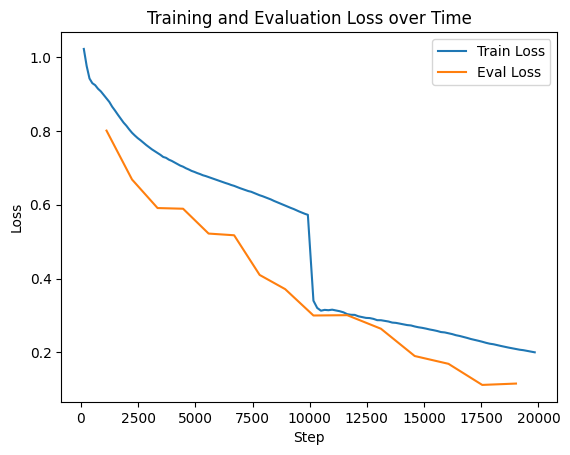

In [ ]:
# Task 2
model_one = Transformer(vocab_size=27, max_seq_len=20, d_model=64, d_internal=32, num_classes=3, d_ff=128, num_layers=1, num_heads=1)
optimizer = Adam(model_one.parameters(), lr=0.001)
num_epochs = 2
loss_function = NLLLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
train_losses, train_steps, eval_losses, eval_steps = train_loop(model_one, train_indices, eval_indices, train_task2, eval_task2, num_epochs, optimizer, loss_function, None)
plot_losses(train_losses, train_steps, eval_losses, eval_steps)

Epoch 1, Step 1215, Train Loss: 0.6253, Eval Loss: 0.4922, Accuracy: 0.7855, F1 Score: 0.7128
Epoch 1, Step 2430, Train Loss: 0.5212, Eval Loss: 0.3954, Accuracy: 0.8304, F1 Score: 0.7578
Epoch 1, Step 3645, Train Loss: 0.4510, Eval Loss: 0.2850, Accuracy: 0.8839, F1 Score: 0.8247
Epoch 1, Step 4860, Train Loss: 0.4013, Eval Loss: 0.2283, Accuracy: 0.9044, F1 Score: 0.8599
Epoch 1, Step 6075, Train Loss: 0.3627, Eval Loss: 0.1851, Accuracy: 0.9248, F1 Score: 0.8865
Epoch 1, Step 7290, Train Loss: 0.3319, Eval Loss: 0.1886, Accuracy: 0.9286, F1 Score: 0.8920
Epoch 1, Step 8505, Train Loss: 0.3091, Eval Loss: 0.1772, Accuracy: 0.9267, F1 Score: 0.8903
Epoch 1, Step 9720, Train Loss: 0.2912, Eval Loss: 0.1675, Accuracy: 0.9300, F1 Score: 0.8951
Epoch 1 completed. Learning rate: 0.000900
Epoch 2, Step 11330, Train Loss: 0.1408, Eval Loss: 0.1503, Accuracy: 0.9355, F1 Score: 0.9098
Epoch 2, Step 12850, Train Loss: 0.1372, Eval Loss: 0.1432, Accuracy: 0.9393, F1 Score: 0.9135
Epoch 2, Step 1

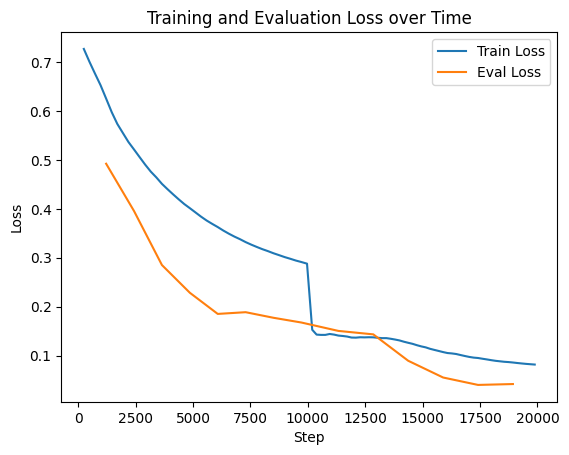

In [ ]:
# With scheduler - Task 1
model = Transformer(vocab_size=27, max_seq_len=20, d_model=64, d_internal=32, num_classes=3, d_ff=128, num_layers=1, num_heads=1)
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 2
loss_function = NLLLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
train_losses, train_steps, eval_losses, eval_steps = train_loop(model, train_indices, eval_indices, train_task1, eval_task1, num_epochs, optimizer, loss_function, scheduler)
plot_losses(train_losses, train_steps, eval_losses, eval_steps)

Epoch 1, Step 1620, Train Loss: 0.7978, Eval Loss: 0.6203, Accuracy: 0.7156, F1 Score: 0.7132
Epoch 1, Step 3240, Train Loss: 0.6656, Eval Loss: 0.4334, Accuracy: 0.8014, F1 Score: 0.8014
Epoch 1, Step 4860, Train Loss: 0.5659, Eval Loss: 0.3084, Accuracy: 0.8707, F1 Score: 0.8693
Epoch 1, Step 6480, Train Loss: 0.4961, Eval Loss: 0.2444, Accuracy: 0.8953, F1 Score: 0.8950
Epoch 1, Step 8100, Train Loss: 0.4433, Eval Loss: 0.2484, Accuracy: 0.8996, F1 Score: 0.8998
Epoch 1, Step 9720, Train Loss: 0.4029, Eval Loss: 0.1747, Accuracy: 0.9261, F1 Score: 0.9248
Epoch 1 completed. Learning rate: 0.000900
Epoch 2, Step 11216, Train Loss: 0.1618, Eval Loss: 0.1487, Accuracy: 0.9405, F1 Score: 0.9404
Epoch 2, Step 12584, Train Loss: 0.1479, Eval Loss: 0.1076, Accuracy: 0.9609, F1 Score: 0.9607
Epoch 2, Step 13952, Train Loss: 0.1355, Eval Loss: 0.1056, Accuracy: 0.9605, F1 Score: 0.9603
Epoch 2, Step 15320, Train Loss: 0.1273, Eval Loss: 0.0776, Accuracy: 0.9722, F1 Score: 0.9720
Epoch 2, Step

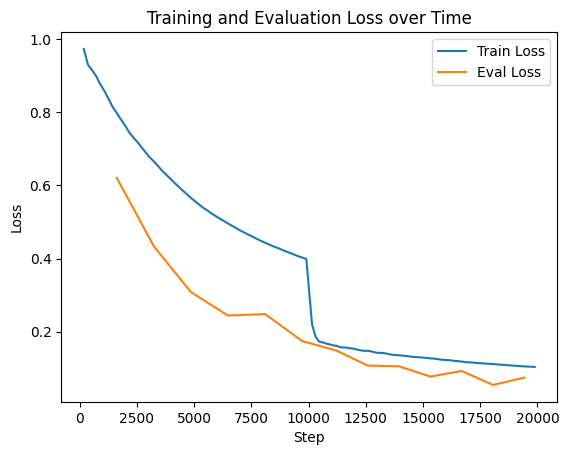

In [ ]:
# With scheduler - Task 2
model = Transformer(vocab_size=27, max_seq_len=20, d_model=64, d_internal=32, num_classes=3, d_ff=128, num_layers=1, num_heads=1)
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 2
loss_function = NLLLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
train_losses, train_steps, eval_losses, eval_steps = train_loop(model, train_indices, eval_indices, train_task2, eval_task2, num_epochs, optimizer, loss_function, scheduler)
plot_losses(train_losses, train_steps, eval_losses, eval_steps)

Epoch 1, Step 1035, Train Loss: 0.6582, Eval Loss: 0.5561, Accuracy: 0.7498, F1 Score: 0.6837
Epoch 1, Step 2070, Train Loss: 0.5640, Eval Loss: 0.4449, Accuracy: 0.8009, F1 Score: 0.7288
Epoch 1, Step 3105, Train Loss: 0.4988, Eval Loss: 0.3251, Accuracy: 0.8668, F1 Score: 0.8188
Epoch 1, Step 4140, Train Loss: 0.4435, Eval Loss: 0.2378, Accuracy: 0.9059, F1 Score: 0.8761
Epoch 1, Step 5175, Train Loss: 0.3949, Eval Loss: 0.1711, Accuracy: 0.9311, F1 Score: 0.9052
Epoch 1, Step 6210, Train Loss: 0.3536, Eval Loss: 0.1217, Accuracy: 0.9591, F1 Score: 0.9372
Epoch 1, Step 7245, Train Loss: 0.3181, Eval Loss: 0.0801, Accuracy: 0.9738, F1 Score: 0.9611
Epoch 1, Step 8280, Train Loss: 0.2894, Eval Loss: 0.0824, Accuracy: 0.9739, F1 Score: 0.9601
Epoch 1, Step 9315, Train Loss: 0.2664, Eval Loss: 0.0618, Accuracy: 0.9810, F1 Score: 0.9720
Epoch 2, Step 10412, Train Loss: 0.0795, Eval Loss: 0.0539, Accuracy: 0.9837, F1 Score: 0.9753
Epoch 2, Step 10927, Train Loss: 0.0679, Eval Loss: 0.0636,

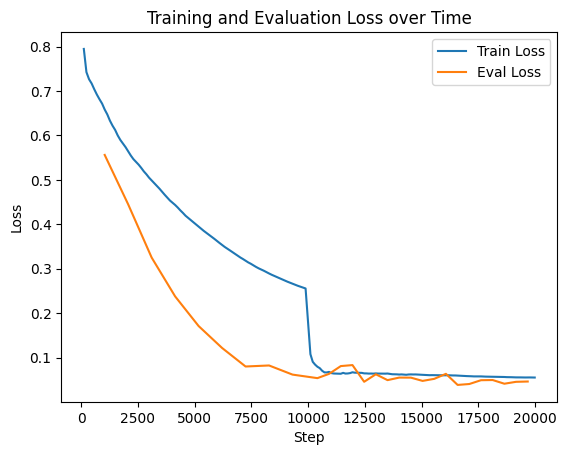

In [ ]:
# Task 1 - With AdamW

model = Transformer(vocab_size=27, max_seq_len=20, d_model=64, d_internal=32, num_classes=3, d_ff=128, num_layers=1, num_heads=1)
optimizer = AdamW(model.parameters(), lr=0.001)
num_epochs = 2
loss_function = NLLLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
train_losses, train_steps, eval_losses, eval_steps = train_loop(model, train_indices, eval_indices, train_task1, eval_task1, num_epochs, optimizer, loss_function, None)
plot_losses(train_losses, train_steps, eval_losses, eval_steps)

Epoch 1, Step 2020, Train Loss: 0.8722, Eval Loss: 0.8074, Accuracy: 0.6067, F1 Score: 0.5870
Epoch 1, Step 4040, Train Loss: 0.7775, Eval Loss: 0.5836, Accuracy: 0.7307, F1 Score: 0.7204
Epoch 1, Step 6060, Train Loss: 0.6931, Eval Loss: 0.4590, Accuracy: 0.7965, F1 Score: 0.7889
Epoch 1, Step 8080, Train Loss: 0.6235, Eval Loss: 0.3567, Accuracy: 0.8469, F1 Score: 0.8417
Epoch 2, Step 10500, Train Loss: 0.2989, Eval Loss: 0.3005, Accuracy: 0.8732, F1 Score: 0.8703
Epoch 2, Step 11400, Train Loss: 0.3015, Eval Loss: 0.2480, Accuracy: 0.9022, F1 Score: 0.9008
Epoch 2, Step 12300, Train Loss: 0.2864, Eval Loss: 0.2493, Accuracy: 0.8962, F1 Score: 0.8946
Epoch 2, Step 13200, Train Loss: 0.2733, Eval Loss: 0.2495, Accuracy: 0.9039, F1 Score: 0.9003
Epoch 2, Step 14100, Train Loss: 0.2613, Eval Loss: 0.2141, Accuracy: 0.9204, F1 Score: 0.9184
Epoch 2, Step 15000, Train Loss: 0.2506, Eval Loss: 0.2010, Accuracy: 0.9237, F1 Score: 0.9215
Epoch 2, Step 15900, Train Loss: 0.2420, Eval Loss: 0.

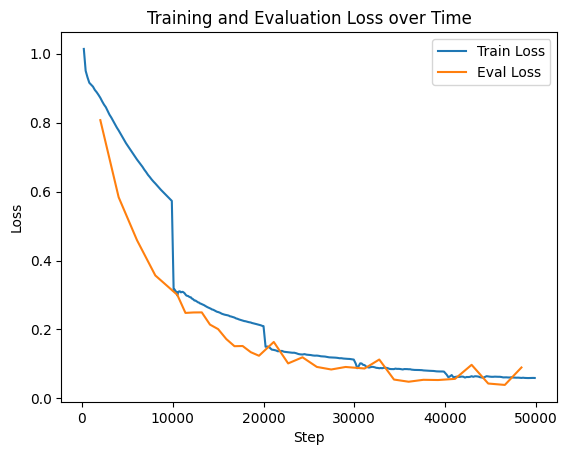

In [ ]:
# Task 2 - With different hyperparameters

model = Transformer(vocab_size=27, max_seq_len=20, d_model=32, d_internal=16, num_classes=3, d_ff=64, num_layers=1, num_heads=1)
optimizer = AdamW(model.parameters(), lr=0.001)
num_epochs = 5
loss_function = NLLLoss()
train_losses, train_steps, eval_losses, eval_steps = train_loop(model, train_indices, eval_indices, train_task2, eval_task2, num_epochs, optimizer, loss_function, None)
plot_losses(train_losses, train_steps, eval_losses, eval_steps)

Hyperparameter selection as can be seen from the above experiments was quite challenging. NLLLoss was the only usable loss function from the given imports of loss functions because it is made to be used with logits (after softmax being applied) while Cross Entropy Loss requires raw logits and BCELoss is for a binary usecase and here we have 3 classes. Regarding hyperparameters d_model, d_internal and d_ff could be altered based on avilable compute. Keeping it on the low (32, 16, 64) required more epochs and led to a more hazy learning curve. The combination (64, 32, 128) was quite beneficial to smoothly reach a good amount of accuracy and macro F1 scores. For the case of loss functions I found that AdamW performed better than Adam with reachining optimum learning curve faster. The other loss funcions were not considered since it was deemed not appropriate for the case of transformers. I performed two more experiments with StepLR schedulers and the change to learning rate was set at 1 epoch. There was a nominal performance boost observed when schedulers were used to alter learning rates.

# Part 5 Deliverable

Question 5.1

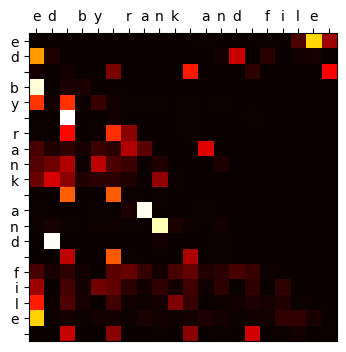

In [ ]:
# Check attention map - Task 1

line = "ed by rank and file "
model.eval()
with torch.no_grad():
    indices = indexer(line)
    _, atten_maps = model(indices)
plot_maps(atten_maps[0][0].unsqueeze(0).unsqueeze(0), line)

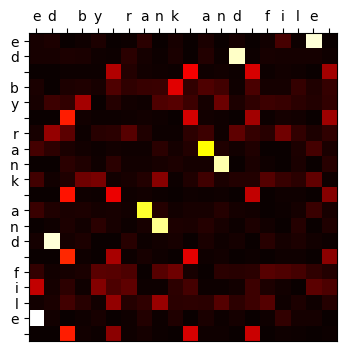

In [ ]:
# Check attention map - Task 2

line = "ed by rank and file "
model_one.eval()
with torch.no_grad():
    indices = indexer(line)
    _, atten_maps = model_one(indices)
plot_maps(atten_maps[0][0].unsqueeze(0).unsqueeze(0), line)

From Task 1 it can be seen that the emphasis is based on occurances of letters previously seen in the sentence showing why only one side of the diagonal has bright spots. As we move forward in the sentence, the cosine patterns for previously occurring letters gets brighter. For example the patterns for repeated words like 'e', 'a', 'n', 'd', ' ' have an dark orange to yellowish heat map towards it showing that the cells are answering the query "how many times has this letter occured previously" and keys answering them so as to present a lower cosine score. Hence, we can see how W_q and W_k have learnt the task at hand and the heatmap is the answer.

For Task 2 it focuses on both previous and future tokens and hence, the attention is more spread out. The heat map is more dense and uniform hinting to attending a broader range of positions. The same arguement as Task 1 applies to Task 2 as well just that attention map has a projection across the diagonal of Task 1 to account for future outcomes.

Question 5.2

Epoch 1, Step 1250, Train Loss: 0.5614, Eval Loss: 0.4272, Accuracy: 0.8401, F1 Score: 0.7776
Epoch 1, Step 2500, Train Loss: 0.4216, Eval Loss: 0.2262, Accuracy: 0.9160, F1 Score: 0.8806
Epoch 1, Step 3750, Train Loss: 0.3417, Eval Loss: 0.1691, Accuracy: 0.9440, F1 Score: 0.9178
Epoch 1, Step 5000, Train Loss: 0.2923, Eval Loss: 0.1027, Accuracy: 0.9704, F1 Score: 0.9591
Epoch 1, Step 6250, Train Loss: 0.2600, Eval Loss: 0.1513, Accuracy: 0.9591, F1 Score: 0.9438
Epoch 1, Step 7500, Train Loss: 0.2328, Eval Loss: 0.1552, Accuracy: 0.9539, F1 Score: 0.9388
Epoch 1, Step 8750, Train Loss: 0.2124, Eval Loss: 0.0731, Accuracy: 0.9788, F1 Score: 0.9696
Epoch 1, Step 10000, Train Loss: 0.1963, Eval Loss: 0.1198, Accuracy: 0.9740, F1 Score: 0.9606


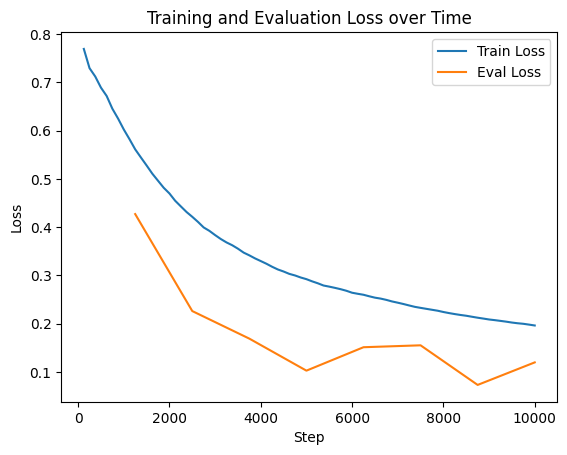

In [ ]:
# Task 1 - Multi Layer
model_multi = Transformer(vocab_size=27, max_seq_len=20, d_model=64, d_internal=32, num_classes=3, d_ff=128, num_layers=5, num_heads=1)
optimizer = Adam(model_multi.parameters(), lr=0.001)
num_epochs = 1
loss_function = NLLLoss()
train_losses, train_steps, eval_losses, eval_steps = train_loop(model_multi, train_indices, eval_indices, train_task1, eval_task1, num_epochs, optimizer, loss_function, None)
plot_losses(train_losses, train_steps, eval_losses, eval_steps)

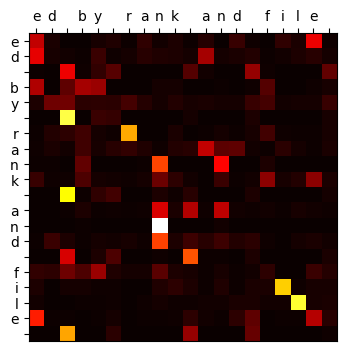

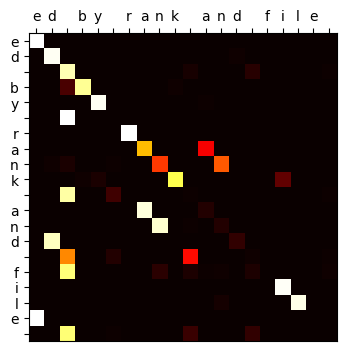

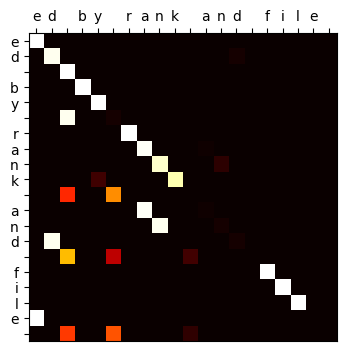

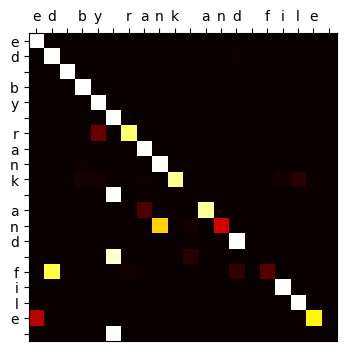

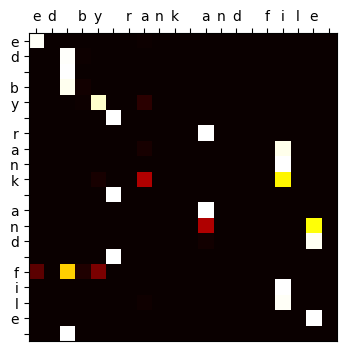

In [ ]:
# Check attention map - Task 1 - Multi Layer (5 Layers)

line = "ed by rank and file "
model_multi.eval()
with torch.no_grad():
    indices = indexer(line)
    _, atten_maps = model_multi(indices)
for atten_map in atten_maps:
    plot_maps(atten_map[0].unsqueeze(0).unsqueeze(0), line)

The above attention maps represent learnings for Task 1 (previous occurances) when there is a single head but 5 layers. My hypothesis is that the queries asked per attention head per layer would be quite similar but would vary by the range of dependencies in consideration. The inital head seems to account for both local and global dependencies or occurances for the letters. But, as the attention heads proceed, they account for more local or adjacent dependencies and finally towards positional tracking. Hence, there are more bright spots seen across the diagonal. As the heads progress there are lesser and only important long range dependencies in consideration which hence, this gives a holistic view of learning for the task at hand.

Question 5.3

Epoch 1, Step 1180, Train Loss: 0.8238, Eval Loss: 0.6171, Accuracy: 0.7238, F1 Score: 0.7030
Epoch 1, Step 2360, Train Loss: 0.6782, Eval Loss: 0.4618, Accuracy: 0.7932, F1 Score: 0.7832
Epoch 1, Step 3540, Train Loss: 0.5943, Eval Loss: 0.3657, Accuracy: 0.8435, F1 Score: 0.8386
Epoch 1, Step 4720, Train Loss: 0.5386, Eval Loss: 0.3500, Accuracy: 0.8530, F1 Score: 0.8502
Epoch 1, Step 5900, Train Loss: 0.4945, Eval Loss: 0.2724, Accuracy: 0.8815, F1 Score: 0.8805
Epoch 1, Step 7080, Train Loss: 0.4574, Eval Loss: 0.2608, Accuracy: 0.8891, F1 Score: 0.8885
Epoch 1, Step 8260, Train Loss: 0.4268, Eval Loss: 0.2557, Accuracy: 0.8996, F1 Score: 0.8980
Epoch 1, Step 9440, Train Loss: 0.4025, Eval Loss: 0.2376, Accuracy: 0.8971, F1 Score: 0.8970
Epoch 2, Step 10736, Train Loss: 0.2164, Eval Loss: 0.2090, Accuracy: 0.9226, F1 Score: 0.9222
Epoch 2, Step 12208, Train Loss: 0.2031, Eval Loss: 0.1973, Accuracy: 0.9205, F1 Score: 0.9194
Epoch 2, Step 13680, Train Loss: 0.2008, Eval Loss: 0.1831

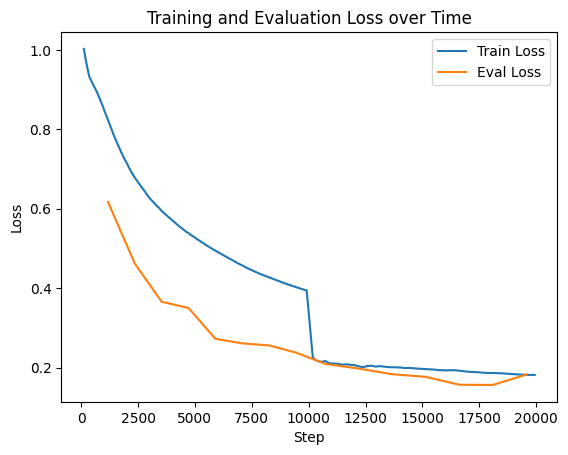

In [ ]:
# Task 2 - Multi Headed (5 heads)
model_multi = Transformer(vocab_size=27, max_seq_len=20, d_model=64, d_internal=32, num_classes=3, d_ff=128, num_layers=1, num_heads=5)
optimizer = Adam(model_multi.parameters(), lr=0.001)
num_epochs = 2
loss_function = NLLLoss()
train_losses, train_steps, eval_losses, eval_steps = train_loop(model_multi, train_indices, eval_indices, train_task2, eval_task2, num_epochs, optimizer, loss_function, None)
plot_losses(train_losses, train_steps, eval_losses, eval_steps)

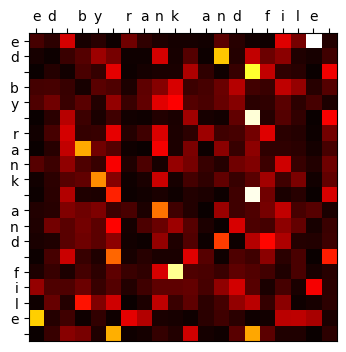

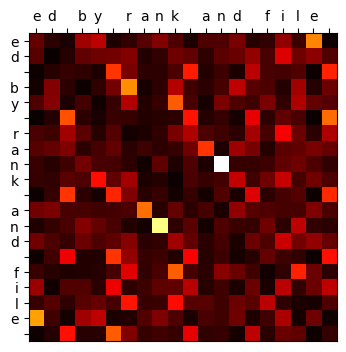

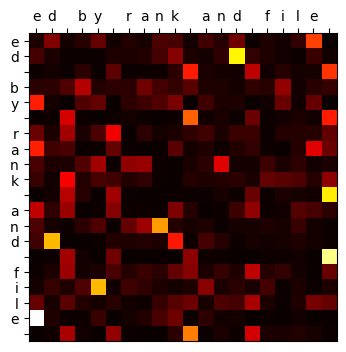

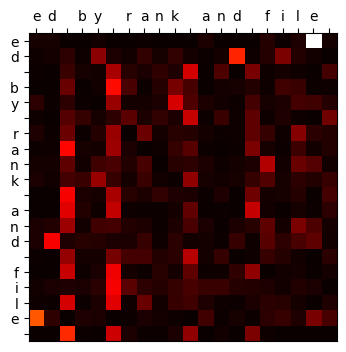

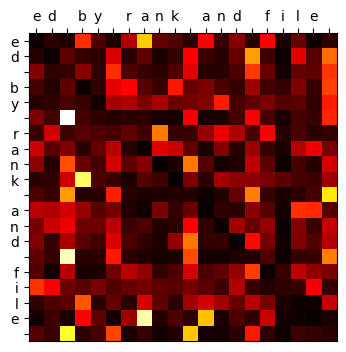

In [ ]:
# Check attention map - Task 1 - Multi Layer (5 Layers)

line = "ed by rank and file "
model_multi.eval()
with torch.no_grad():
    indices = indexer(line)
    _, atten_maps = model_multi(indices)
for atten_map in atten_maps[0]:
    plot_maps(atten_map.unsqueeze(0).unsqueeze(0), line)

The above attention maps are for Task 2 when 5 heads are present in one layer and there is only one layer in consideration. The advantage of having multiple heads per layer is the range of queries that can be asked and learnings that can be made possible in a single layer i.e this would lead to a more comprehensive learning and would lessen the need to go deeper by increasing the number of layers. Here we can hypothesize that the attention is scattered to account for bidirectional ocuurance of a token or letter. The different attention maps might signify different range of dependencies captured. While some heatmaps migt look into local token dependencies, others mights look ahead birectionally accross different ranges to understand all characteristics of letter occurance. If we increase the number of heads more, we might possibly even see seperate attention maps for more commonly ocurring letters. Therefore, we can say that these attention maps might represent different ranges of lookups from a letter to find occurances of that letter, which quite evident by the bright spots of each heatmap.